In [1]:
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning) 

import hddm
from sys import platform
import numpy as np
import seaborn as sns
import pandas as pd
from jupyterthemes import jtplot
import matplotlib.pyplot as plt
from kabuki.analyze import gelman_rubin



jtplot.style(theme='onedork')
jtplot.style(context='poster', fscale=2, spines=False, gridlines='--')
sns.set_color_codes("muted")

/home/krista/anaconda3/envs/test_hddm/lib/python2.7/site-packages/IPython/parallel.py:13: ShimWarning: The `IPython.parallel` package has been deprecated since IPython 4.0. You should import from ipyparallel instead.
  "You should import from ipyparallel instead.", ShimWarning)


In [2]:
if platform == 'linux2':
    home = '/home/krista/'
elif platform == 'darwin': 
    home = '/Users/Krista/'

In [3]:
all_obs_data = hddm.load_csv(home + 'Dropbox/loki_0.5/analysis/aggregated_data/reward_ls_combined.csv')
all_obs_data = all_obs_data.rename(index=str, columns={"p_accuracy": "response",
                                                       "subj_id": "subj_idx"})
all_obs_data = all_obs_data[['response', 'rt', 'reward_code', 'subj_idx', 'ideal_B', 'cpp']] 
all_obs_data.reset_index(drop=True, inplace=True)

In [4]:
all_obs_data.head()

,response,rt,reward_code,subj_idx,ideal_B,cpp
0,1,0.527092,0,786,0.000000,0.059362
1,1,0.474282,0,786,-0.089044,0.052305
2,1,0.500100,0,786,-0.162844,0.228329
3,1,0.534169,0,786,0.495797,0.072673
4,0,0.644987,0,786,-0.068358,0.878912


In [5]:
all_obs_data['cpp_shifted'] = all_obs_data.cpp.shift(1)
all_obs_data['ideal_B_shifted'] = all_obs_data.ideal_B.shift(1)

In [6]:
all_obs_data.dropna(inplace=True) #need to drop nas for HDDMRegressor

In [7]:
n_samples, n_burn = 3000, 500
n_effective_samples = n_samples - n_burn
subjects = all_obs_data.subj_idx.unique()

model_specifications = [('a~cpp_shifted', 'v~ideal_B_shifted'),('v~cpp_shifted', 'a~ideal_B_shifted'),
          ('a~ideal_B_shifted'),('v~ideal_B_shifted'), 
         ('a~cpp_shifted'), ('v~cpp_shifted'), ('a~1', 't~1', 'v~1')]
model_names = ['a_cpp_v_B', 'v_cpp_a_B', 'a_B', 'v_B', 'a_cpp', 'v_cpp', 'intercept']

model_inputs = dict(zip(model_names, model_specifications))
model_objects = dict()

In [8]:
def estimate_regression_model(model_specification, model_name, subject, data, model_objects,
                              n_samples=n_samples, n_burn=n_burn, accuracy_coding=True, convergence_iteration=None):
    
    if accuracy_coding: 
        reg_model = hddm.HDDMRegressor(data = data, models = model_specification, bias=False, group_only_regressors=True, p_outlier=0.05) #accuracy coded
        reg_model.find_starting_values()
        reg_model.sample(n_samples, burn = n_burn, dbname = model_name, db='pickle')
    else: 
        reg_model = hddm.HDDMRegressor(data = data, models = model_specification, bias=True, group_only_regressors=True, p_outlier=0.05) #stim coded
        reg_model.find_starting_values()
        reg_model.sample(n_samples, burn=n_burn, dbname=model_name+'.db', db='pickle')
    
    if convergence_iteration is None: 
        model_objects[model_name + '_' + str(subject)] = reg_model
    else:
        model_objects[model_name + '_' + str(subject) + '_iter' + str(convergence_iteration)] = reg_model

In [22]:
for subject in subjects:
    sub_data = all_obs_data.loc[all_obs_data.subj_idx == subject,]
    for model_name, model_specification in model_inputs.items(): 
        estimate_regression_model(model_specification, model_name, subject, sub_data, model_objects)
        print('model sampling complete')

Adding these covariates:
['a_Intercept', 'a_cpp_shifted']
Adding these covariates:
['v_Intercept', 'v_ideal_B_shifted']
-2766.97427426
-2766.95806462
 [-----------------100%-----------------] 3000 of 3000 complete in 303.6 secmodel sampling complete
Adding these covariates:
['a_Intercept', 'a_cpp_shifted']
-2821.87345873
-2821.86943503
 [-----------------100%-----------------] 3000 of 3000 complete in 195.8 secmodel sampling complete
Adding these covariates:
['v_Intercept', 'v_cpp_shifted']
-2813.75629996
-2813.75570349
 [-----------------100%-----------------] 3000 of 3000 complete in 221.3 secmodel sampling complete
Adding these covariates:
['a_Intercept']
Adding these covariates:
['t_Intercept']
Adding these covariates:
['v_Intercept']
-2818.41242881
-2818.41242774
 [-----------------100%-----------------] 3000 of 3000 complete in 198.1 secmodel sampling complete
Adding these covariates:
['a_Intercept', 'a_ideal_B_shifted']
-2821.15713074
-2821.15515864
 [-----------------100%------

In [10]:
#run each model for each subject 5 times to estimate between-chain variance 
n_convergence_iterations = 5
model_convergence_objects = dict() 

for subject in subjects:
    sub_data = all_obs_data.loc[all_obs_data.subj_idx == subject,]
    for convergence_iteration in range(n_convergence_iterations):
        for model_name, model_specification in model_inputs.items(): 
            estimate_regression_model(model_specification=model_specification, model_name = model_name, subject=subject, 
                                      data=sub_data, model_objects=model_convergence_objects, convergence_iteration=convergence_iteration)

Adding these covariates:
['a_Intercept', 'a_cpp_shifted']
Adding these covariates:
['v_Intercept', 'v_ideal_B_shifted']
-2766.98275817
-2766.95877057
 [-----------------100%-----------------] 3000 of 3000 complete in 287.6 secAdding these covariates:
['a_Intercept', 'a_cpp_shifted']
-2821.86952375
-2821.86783765
 [-----------------100%-----------------] 3001 of 3000 complete in 200.5 secAdding these covariates:
['v_Intercept', 'v_cpp_shifted']
-2813.75568882
-2813.75566734
 [-----------------100%-----------------] 3000 of 3000 complete in 229.9 secAdding these covariates:
['a_Intercept']
Adding these covariates:
['t_Intercept']
Adding these covariates:
['v_Intercept']
-2818.41242796
-2818.41242774
 [-----------------100%-----------------] 3000 of 3000 complete in 204.8 secAdding these covariates:
['a_Intercept', 'a_ideal_B_shifted']
-2821.15713069
-2821.15515864
 [-----------------100%-----------------] 3000 of 3000 complete in 183.0 secAdding these covariates:
['v_Intercept', 'v_ideal

-2703.26434154
 [-----------------100%-----------------] 3001 of 3000 complete in 295.0 secAdding these covariates:
['a_Intercept', 'a_cpp_shifted']
-2722.5393282
-2722.53931492
 [-----------------100%-----------------] 3000 of 3000 complete in 210.9 secAdding these covariates:
['v_Intercept', 'v_cpp_shifted']
-2709.37434985
-2709.37361329
 [-----------------100%-----------------] 3000 of 3000 complete in 233.9 secAdding these covariates:
['a_Intercept']
Adding these covariates:
['t_Intercept']
Adding these covariates:
['v_Intercept']
-2719.02506584
-2719.02505498
 [-----------------100%-----------------] 3000 of 3000 complete in 233.7 secAdding these covariates:
['a_Intercept', 'a_ideal_B_shifted']
-2722.62092787
-2722.62092053
 [-----------------100%-----------------] 3000 of 3000 complete in 194.0 secAdding these covariates:
['v_Intercept', 'v_ideal_B_shifted']
-2699.79222824
-2699.79218442
 [-----------------100%-----------------] 3000 of 3000 complete in 195.8 secAdding these cova

-1586.58955325
-1586.58836697
 [-----------------100%-----------------] 3000 of 3000 complete in 187.2 secAdding these covariates:
['v_Intercept', 'v_cpp_shifted']
-1584.15671301
-1584.15653984
 [-----------------100%-----------------] 3001 of 3000 complete in 236.1 secAdding these covariates:
['a_Intercept']
Adding these covariates:
['t_Intercept']
Adding these covariates:
['v_Intercept']
-1583.77845819
-1583.77845819
 [-----------------100%-----------------] 3000 of 3000 complete in 229.4 secAdding these covariates:
['a_Intercept', 'a_ideal_B_shifted']
-1586.2847177
-1586.2607168
 [-----------------100%-----------------] 3000 of 3000 complete in 178.1 secAdding these covariates:
['v_Intercept', 'v_ideal_B_shifted']
-1581.56483164
-1581.56481599
 [-----------------100%-----------------] 3000 of 3000 complete in 188.2 secAdding these covariates:
['v_Intercept', 'v_cpp_shifted']
Adding these covariates:
['a_Intercept', 'a_ideal_B_shifted']
-1586.60527237
-1586.60451084
 [---------------

-2737.66086655
-2737.6553215
 [-----------------100%-----------------] 3001 of 3000 complete in 231.1 secAdding these covariates:
['a_Intercept']
Adding these covariates:
['t_Intercept']
Adding these covariates:
['v_Intercept']
-2735.33901107
-2735.33900957
 [-----------------100%-----------------] 3000 of 3000 complete in 204.3 secAdding these covariates:
['a_Intercept', 'a_ideal_B_shifted']
-2738.93374925
-2738.93262583
 [-----------------100%-----------------] 3000 of 3000 complete in 184.9 secAdding these covariates:
['v_Intercept', 'v_ideal_B_shifted']
-2736.37198087
-2736.37104437
 [-----------------100%-----------------] 3000 of 3000 complete in 188.4 secAdding these covariates:
['v_Intercept', 'v_cpp_shifted']
Adding these covariates:
['a_Intercept', 'a_ideal_B_shifted']
-2741.24246712
-2741.2421866
 [-----------------100%-----------------] 3001 of 3000 complete in 320.7 secAdding these covariates:
['a_Intercept', 'a_cpp_shifted']
Adding these covariates:
['v_Intercept', 'v_ide

In [174]:
n_models = len(model_names)
print(n_models)
len(model_convergence_objects) == (len(subjects) * n_convergence_iterations * n_models)

7


True

In [173]:
var_criterion = 1.1 #max. acceptable ratio of between to within chain variance (see Gelman)
subjects = all_obs_data.subj_idx.unique().astype('str')
search_strings = [model_name + '_' +  subject for model in model_names for subject in subjects]

In [171]:
unconverged = list()

for string in search_strings:
        data = dict((key, value) for key, value in model_convergence_objects.iteritems() if key.startswith(string))
        R_dict = gelman_rubin(data.values()) #create dict of R hat statistics for each parameter  
        print(R_dict)
        unconverged.append(any(param > var_criterion for param in R_dict.itervalues())) #check whether stat. exceeds criterion 

{'v_cpp_shifted': 0.999935447542454, 'a_ideal_B_shifted': 0.99994045962027, 't': 1.0000411801303428, 'v_Intercept': 0.9998686759703004, 'a_Intercept': 0.9998341521661835}
{'v_cpp_shifted': 1.0003941480027585, 'a_ideal_B_shifted': 1.0003409236524923, 't': 1.0001499451394422, 'v_Intercept': 1.0001966288523347, 'a_Intercept': 1.0002534367568283}
{'v_cpp_shifted': 1.0002923095869156, 'a_ideal_B_shifted': 1.0001021212173138, 't': 0.9999955228624529, 'v_Intercept': 1.0000910196668698, 'a_Intercept': 1.0000059142986284}
{'v_cpp_shifted': 1.0005896963565575, 'a_ideal_B_shifted': 1.0002913040619337, 't': 1.0000350548403087, 'v_Intercept': 1.0008602827009014, 'a_Intercept': 1.0005686671023053}
{'v_cpp_shifted': 0.999935447542454, 'a_ideal_B_shifted': 0.99994045962027, 't': 1.0000411801303428, 'v_Intercept': 0.9998686759703004, 'a_Intercept': 0.9998341521661835}
{'v_cpp_shifted': 1.0003941480027585, 'a_ideal_B_shifted': 1.0003409236524923, 't': 1.0001499451394422, 'v_Intercept': 1.000196628852334

In [172]:
n_unconverged_params = sum(unconverged) #find number of unconverged parameters 
print('all parameters have converged:' , n_unconverged_params == 0)

('all parameters have converged:', True)


In [50]:
locals().update(model_objects) # convert keys and values to variables 

In [73]:
len(subj_df_list) == (len(subjects) * n_models)

True

In [82]:
len(subj_df_all) == (len(subjects)*n_models*n_effective_samples)

True

In [ ]:
a_B = [a_B_786, a_B_787, a_B_788, a_B_789]
v_B = [v_B_786, v_B_787, v_B_788, v_B_789]

In [103]:
a_cpp = [a_cpp_786, a_cpp_787, a_cpp_788, a_cpp_789]
v_cpp = [v_cpp_786, v_cpp_787, v_cpp_788, v_cpp_789]

In [107]:
a_cpp_v_B = [a_cpp_v_B_786, a_cpp_v_B_787, a_cpp_v_B_788, a_cpp_v_B_789]
v_cpp_a_B = [v_cpp_a_B_786, v_cpp_a_B_787, v_cpp_a_B_788, v_cpp_a_B_789]

In [106]:
intercept = [intercept_786, intercept_787, intercept_788, intercept_789]

In [116]:
all_models = [a_cpp_v_B, v_cpp_a_B, a_B, v_B, a_cpp, v_cpp, intercept]
print(model_names)

['a_cpp_v_B', 'v_cpp_a_B', 'a_B', 'v_B', 'a_cpp', 'v_cpp', 'intercept']


In [117]:
model_dict = dict(zip(model_names, all_models))

In [144]:
subj_df_list = []

for model in model_dict:
    for subject in range(len(subjects)):
        subj_df = model_dict[model][subject].get_traces()
        subj_df['subj_idx'] = model_dict[model][subject].data.subj_idx.unique().tolist() * n_effective_samples
        subj_df['model'] = model
        subj_df['dic'] = model_dict[model][subject].dic
        subj_df_list.append(subj_df)
    
subj_df_all = pd.concat(subj_df_list, sort=True)

In [146]:
subj_df_all.head()

,a,a_Intercept,a_cpp_shifted,a_ideal_B_shifted,dic,model,subj_idx,t,t_Intercept,v,v_Intercept,v_cpp_shifted,v_ideal_B_shifted
0,NaN,1.593968,0.013742,NaN,5496.641225,a_cpp_v_B,786,0.000492,NaN,NaN,0.189651,NaN,0.233044
1,NaN,1.593056,0.061873,NaN,5496.641225,a_cpp_v_B,786,0.001322,NaN,NaN,0.205856,NaN,0.223747
2,NaN,1.591611,0.042420,NaN,5496.641225,a_cpp_v_B,786,0.001123,NaN,NaN,0.229877,NaN,0.213089
3,NaN,1.598670,-0.065818,NaN,5496.641225,a_cpp_v_B,786,0.000980,NaN,NaN,0.228464,NaN,0.185507
4,NaN,1.616312,-0.088377,NaN,5496.641225,a_cpp_v_B,786,0.000802,NaN,NaN,0.220422,NaN,0.192042


In [147]:
subj_df_all.model.unique()

array(['a_cpp_v_B', 'a_cpp', 'v_cpp', 'intercept', 'a_B', 'v_B',
       'v_cpp_a_B'], dtype=object)

In [153]:
subj_df_all.groupby(['subj_idx', 'model'])['dic'].unique()

subj_idx  model    
786       a_B           [5610.169195976323]
          a_cpp        [5611.9350992070795]
          a_cpp_v_B     [5496.641225423956]
          intercept     [5610.425275717689]
          v_B           [5494.902360656057]
          v_cpp        [5595.3465177048565]
          v_cpp_a_B     [5595.991341413231]
787       a_B          [5436.8695683145825]
          a_cpp         [5436.726476717771]
          a_cpp_v_B     [5392.700416961814]
          intercept     [5435.048952792971]
          v_B           [5391.179199935176]
          v_cpp         [5410.333479274217]
          v_cpp_a_B      [5412.26017863347]
788       a_B          [3167.0995867115134]
          a_cpp        [3167.6813219689975]
          a_cpp_v_B    [3157.5212957524045]
          intercept    [3166.9388489791154]
          v_B           [3157.671857392594]
          v_cpp        [3162.8122889914785]
          v_cpp_a_B    [3162.7343140713815]
789       a_B           [5459.730741481859]
          a_

In [175]:
a_cpp_v_B_df = subj_df_all.loc[subj_df_all.model == 'a_cpp_v_B']
v_B_df = subj_df_all.loc[subj_df_all.model == 'v_B']

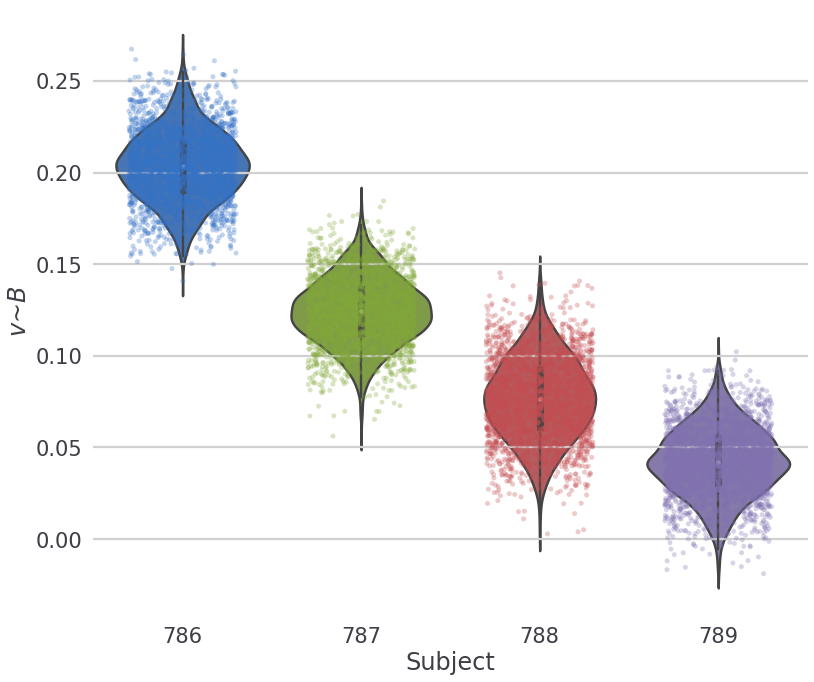

In [326]:
jtplot.style(context='poster', fscale=2, spines=False, theme='grade3')
sns.set_color_codes("muted")

sns.violinplot(x='subj_idx', y='v_ideal_B_shifted', data=a_cpp_v_B_df)
sns.stripplot(x='subj_idx', y='v_ideal_B_shifted', data=a_cpp_v_B_df, alpha=0.3, jitter=0.30)
plt.ylabel(r'$v \textasciitilde B$')
plt.xlabel('Subject')
plt.savefig(home+'Dropbox/loki_0.5/analysis/figures/subj_vB_betas.pdf',dpi=300) #add rotated labels

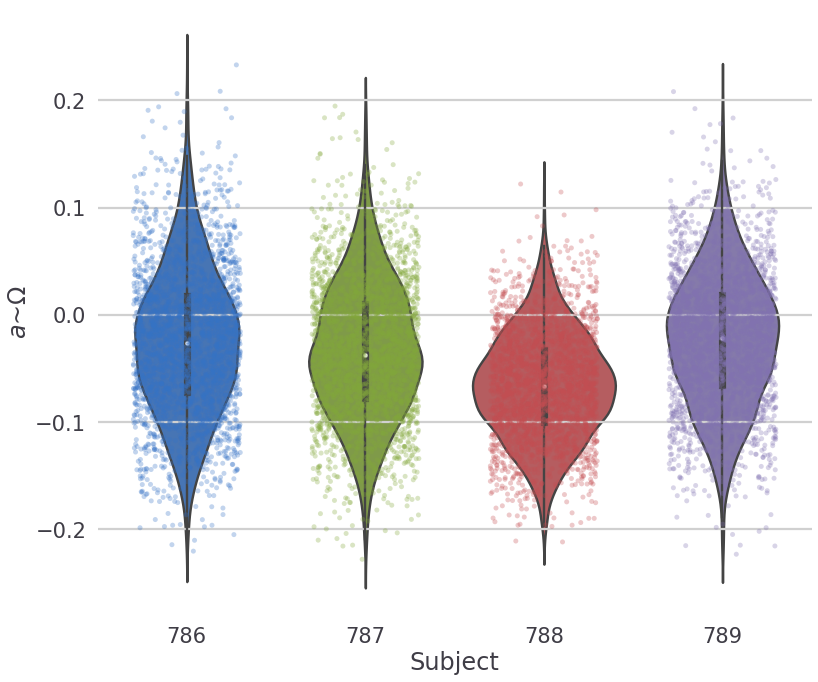

In [327]:
jtplot.style(context='poster', fscale=2, spines=False, theme='grade3')
sns.set_color_codes("muted")

sns.violinplot(x='subj_idx', y='a_cpp_shifted', data=a_cpp_v_B_df)
sns.stripplot(x='subj_idx', y='a_cpp_shifted', data=a_cpp_v_B_df, alpha=0.3, jitter=0.30)
plt.ylabel(r'$a \textasciitilde \Omega$')
plt.xlabel('Subject')
plt.savefig(home+'Dropbox/loki_0.5/analysis/figures/subj_aCPP_betas.pdf',dpi=300) #add rotated labels

In [255]:
dics_df = (subj_df_all.groupby(['subj_idx', 'model'])['dic'].unique() - subj_df_all.loc[subj_df_all.model == 'intercept'].groupby(['subj_idx'])['dic'].unique()).reset_index()

In [259]:
dics_df['raw_dic'] = subj_df_all.groupby(['subj_idx', 'model'])['dic'].unique().reset_index()['dic']

In [260]:
dics_df = dics_df.rename(index=str, columns={"dic": "null_adj_dic"})
dics_df['null_adj_dic'] = dics_df['null_adj_dic'].str[0]
dics_df['raw_dic'] = dics_df['raw_dic'].str[0]

In [261]:
dics_df.head()

,subj_idx,model,null_adj_dic,raw_dic
0,786,a_B,-0.256080,5610.169196
1,786,a_cpp,1.509823,5611.935099
2,786,a_cpp_v_B,-113.784050,5496.641225
3,786,intercept,0.000000,5610.425276
4,786,v_B,-115.522915,5494.902361


In [265]:
subj_df_all.to_csv(home + 'Dropbox/loki_0.5/analysis/aggregated_data/subjectwise_ddm_reg.csv')

In [264]:
dics_df.to_csv(home + 'Dropbox/loki_0.5/analysis/aggregated_data/subjectwise_dics_reg.csv' )